<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
!wget --header="Host: doc-0o-bk-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_nso6dcn1mbidkt5qr539a2jiefc09pqv_nonce=iak2ig7rpq664" --header="Connection: keep-alive" "https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr" -c -O 'storage_sample_stage4.h5'

--2022-06-04 07:46:29--  https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr
Resolving doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)|142.250.141.132|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-06-04 07:46:30 ERROR 403: Forbidden.



In [3]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [8]:
if os.path.isfile('/content/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

DiGraph with 1780722 nodes and 7550015 edges


In [9]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_d=[]
    for i,row in df_final.iterrows():
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
        except:
            d1 = set()
            
        num_followers_d.append(len(d1))
    
    return  num_followers_d

In [10]:
df_final_train['num_followers_d']= compute_features_stage1(df_final_train)
df_final_test['num_followers_d']= compute_features_stage1(df_final_test)

In [11]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d'],
      dtype='object')

In [12]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [13]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9166526528209871 test Score 0.9013412816691506
Estimators =  50 Train Score 0.9220001880268669 test Score 0.9167418346583878
Estimators =  100 Train Score 0.9238986151032139 test Score 0.9186693252177565
Estimators =  250 Train Score 0.9230962264348226 test Score 0.9177498267643786
Estimators =  450 Train Score 0.9232971764164942 test Score 0.915427489746556


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

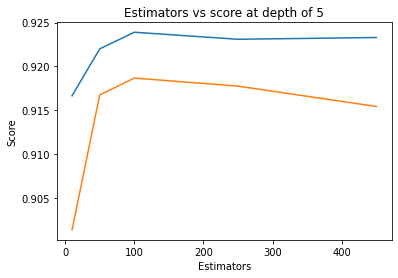

In [15]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1, random_state=25, verbose=0, warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9152049197242973 test Score 0.8915424142869177
depth =  9 Train Score 0.9606702729084474 test Score 0.919987316351337
depth =  11 Train Score 0.9617441966687306 test Score 0.9255614433509967
depth =  15 Train Score 0.9630011732815471 test Score 0.9227016569938599
depth =  20 Train Score 0.9644298356510745 test Score 0.9263286038116029
depth =  35 Train Score 0.9645078742148543 test Score 0.9263294912976843
depth =  50 Train Score 0.9645078742148543 test Score 0.9263294912976843
depth =  70 Train Score 0.9645078742148543 test Score 0.9263294912976843
depth =  130 Train Score 0.9645078742148543 test Score 0.9263294912976843


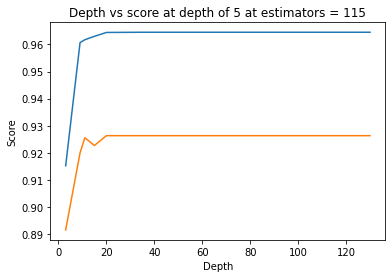

In [16]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [18]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96220943 0.96180762 0.96046817 0.96195034 0.96395907]


In [19]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [21]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [22]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [23]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9658889799055449
Test f1 score 0.9271139474347134


In [24]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


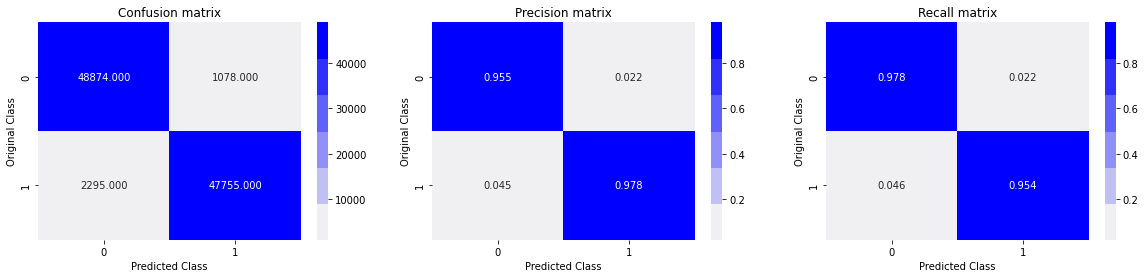

Test confusion_matrix


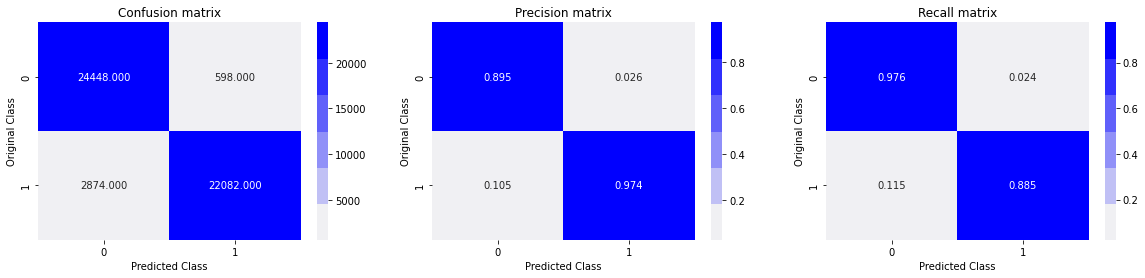

In [25]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

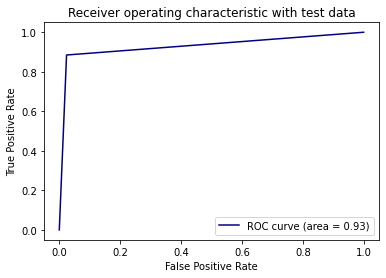

In [26]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

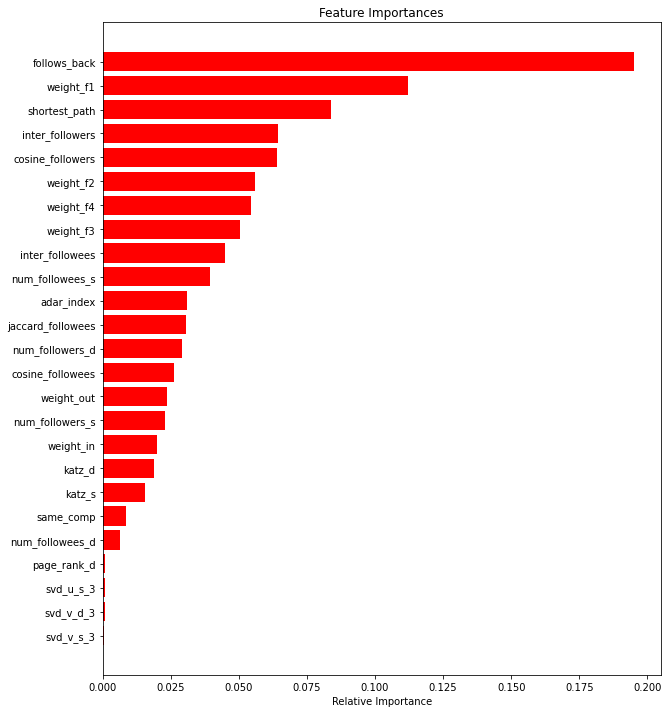

In [27]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

In [28]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [29]:
prefer_attach2=[]
trf=np.array(df_final_test['num_followers_s'])
tef=np.array(df_final_test['num_followers_d'])
for i in range(len(trf)):
 prefer_attach2.append(trf[i]*tef[i])
df_final_test['prefer_att']=prefer_attach2

In [30]:
num_fs=np.array(df_final_train['num_followees_s'])
num_fd=np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(num_fs)):
 preferential_followees.append(num_fd[i]*num_fs[i])
df_final_train['prefer_Attach_followees']= preferential_followees
df_final_train.astype(object)
print(df_final_train.shape)

(100002, 53)


In [31]:
num_fs=np.array(df_final_test['num_followees_s'])
num_fd=np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(num_fs)):
 preferential_followees.append(num_fd[i]*num_fs[i])
df_final_test['prefer_Attach_followees']= preferential_followees
df_final_test.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,num_followers_d,prefer_att,prefer_Attach_followees
0,0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,...,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,14,196,54
1,0,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,...,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,17,289,19
2,0,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,...,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,10,100,144
3,0,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,...,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,37,1369,340
4,0,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,...,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,27,729,405


In [33]:
s1 = df_final_train[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5']].values
d1 = df_final_train[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5']].values
svd_u_dot_train = []
for i in range(df_final_train.shape[0]):
 res = np.dot(s1[i],d1[i])
 svd_u_dot_train.append(res)
s1 = df_final_test[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5']].values
d1 = df_final_test[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5']].values
svd_u_dot_test = []
for i in range(df_final_test.shape[0]):
 res = np.dot(s1[i],d1[i])
 svd_u_dot_test.append(res)
print("svd_dot_train ",len(svd_u_dot_train))
print("svd_dot_test ",len(svd_u_dot_test))

svd_dot_train  100002
svd_dot_test  50002


In [35]:
s2 = df_final_train[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5']].values
d2 = df_final_train[['svd_v_d_1','svd_v_d_2','svd_v_d_3','svd_v_d_4','svd_v_d_5']].values
svd_v_dot_train = []
for i in range(df_final_train.shape[0]):
 res = np.dot(s2[i],d2[i])
 svd_v_dot_train.append(res)
ss = df_final_test[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5']].values
dd = df_final_test[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5']].values
svd_v_dot_test = []
for i in range(df_final_test.shape[0]):
 res = np.dot(s2[i],d2[i])
 svd_v_dot_test.append(res)
print("svd_dot_train ",len(svd_v_dot_train))
print("svd_dot_test ",len(svd_v_dot_test))

svd_dot_train  100002
svd_dot_test  50002


In [36]:
train = pd.DataFrame({'svd_u_dot_train':svd_u_dot_train,'svd_v_dot_train':svd_v_dot_train}).astype(object)
test = pd.DataFrame({'svd_u_dot_test':svd_u_dot_test,'svd_v_dot_test':svd_v_dot_test}).astype(object)
print(train.shape)

(100002, 2)


In [37]:
from scipy.sparse import hstack
X_train = np.hstack((df_final_train,train))
X_test = np.hstack((df_final_test,test))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(100002, 55) (100002,)
(50002, 56) (50002,)


In [38]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
param_dist = {"n_estimators":sp_randint(10,125),
"max_depth": sp_randint(10,15),
"min_child_samples ": sp_randint(25,65)}
clf = LGBMClassifier(random_state=25,n_jobs=-1)
rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)
rf_random.fit(X_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.97365795 0.9751261  0.97543939 0.97219332 0.9773482 ]
mean train scores [0.97460067 0.97678293 0.97724826 0.97269024 0.98052112]


In [41]:
print(rf_random.best_estimator_)

LGBMClassifier(max_depth=13, min_child_samples =49, n_estimators=65,
               random_state=25)


In [42]:
clf =LGBMClassifier(num_leaves=25,max_depth=13,n_estimators=65,min_child_samples=49)

In [44]:
clf.fit(X_train,y_train)

LGBMClassifier(max_depth=13, min_child_samples=49, n_estimators=65,
               num_leaves=25)

In [45]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9786340744628241
Test f1 score 0.9271139474347134


In [46]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
 C = confusion_matrix(test_y, predict_y)
 A =(((C.T)/(C.sum(axis=1))).T)
 B =(C/C.sum(axis=0))
 plt.figure(figsize=(20,4))
 labels = [0,1]
# representing A in heatmap format
 cmap=sns.light_palette("blue")
 plt.subplot(1, 3, 1)
 sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
 plt.ylabel('Original Class')
 plt.title("Confusion matrix")
 plt.subplot(1, 3, 2)
 sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
 plt.ylabel('Original Class')
 plt.title("Precision matrix")
 plt.subplot(1, 3, 3)
 sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
 plt.ylabel('Original Class')
 plt.title("Recall matrix")
 plt.show()

Train confusion_matrix


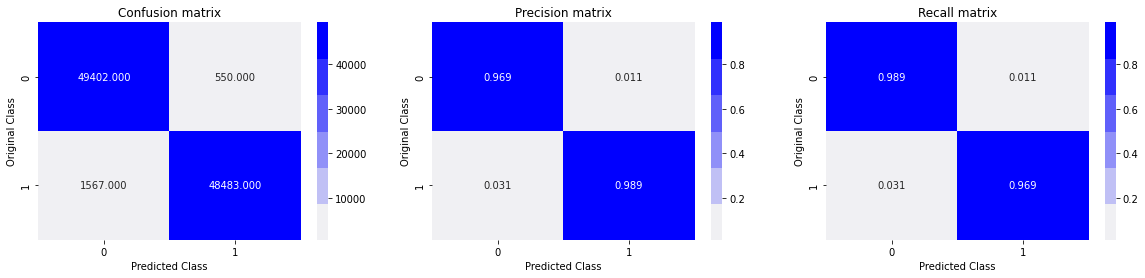

Test confusion_matrix


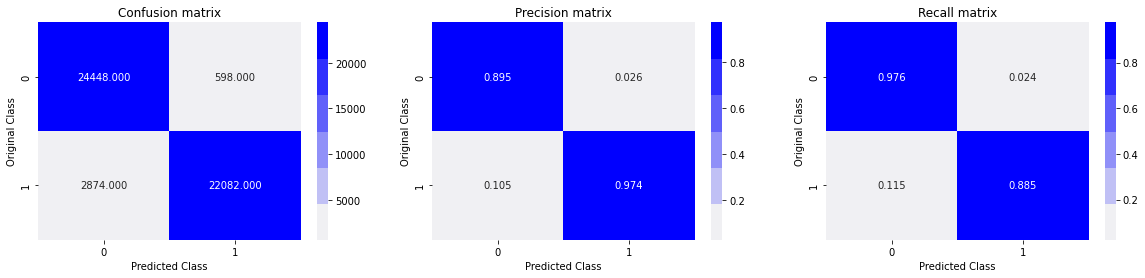

In [47]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

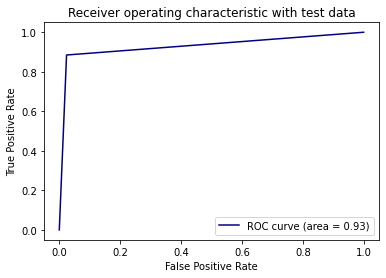

In [48]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [49]:
features=df_final_train.columns
feat=features.append(train.columns)

[53 49 52 45 19 27 54 22 47 29  6  2 13  1 26 21 15 23 14 10  4 11 20  5
 12]


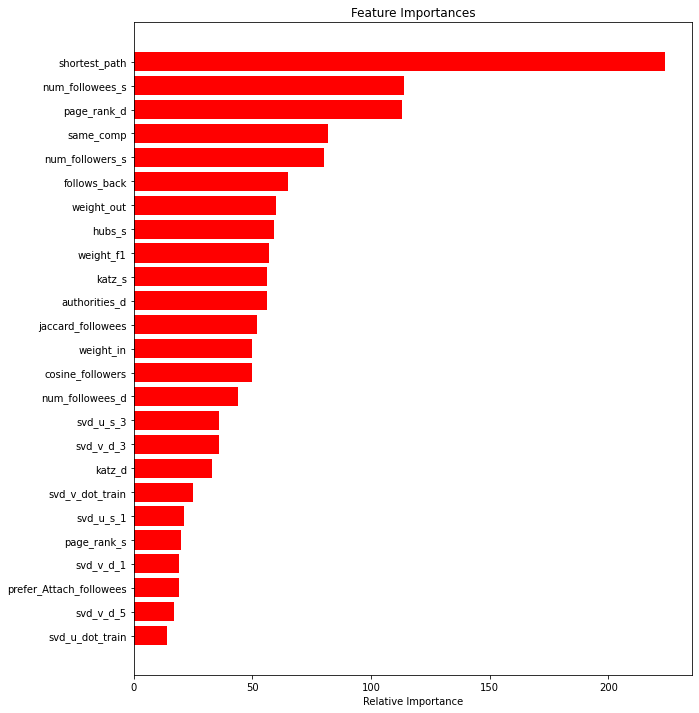

In [50]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
print(indices)
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [feat[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [56]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "n_estimators", "max_depth","Train f1-score","Test f1-Score","Imp Feature"]
x.add_row(['Random Forest','121','14','0.965','0.924','Follows back'])
x.add_row(['XGBOOST','65','13','0.978','0.927','Shortest path'])
print(x)

+---------------+--------------+-----------+----------------+---------------+---------------+
|     Model     | n_estimators | max_depth | Train f1-score | Test f1-Score |  Imp Feature  |
+---------------+--------------+-----------+----------------+---------------+---------------+
| Random Forest |     121      |     14    |     0.965      |     0.924     |  Follows back |
|    XGBOOST    |      65      |     13    |     0.978      |     0.927     | Shortest path |
+---------------+--------------+-----------+----------------+---------------+---------------+


**Observations:**

1) Initially we have only a couple feature in our data-set. First we performed exploratory data analysis on our given data set such as number of followers and followees of each person.

2) Then after we generated some datapoints which were not present in our given data-set, since we had only class label 1 data.

3) Then we did some feature engineering on dataset like finding shortest path, kartz centrality, jaccard distances, page rank, preferential attachements etc.

4) After performing eploratory data analysis and feature engineering we splitted whole dataset into train and test and performed random forest and xgboost taking f1-score as our metric.

5) At the end we plotted confusion matrix and pretty-table for both algorithm and found best hyperparameters.